In [1]:
import numpy as np
import pandas as pd
from spectral import *
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import *
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import rand_score, accuracy_score, silhouette_score, adjusted_rand_score, v_measure_score
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

image = np.load('salinas_image.npy')
gt = np.load('salinas_labels.npy')

In [2]:
crop_type = ["Undefined", "Brocoli_green_weeds_1", "Brocoli_green_weeds_2", "Fallow","Fallow_rough_plow", "Fallow_smooth", "Stubble","Celery", "Grapes_untrained","Soil_vinyard_develop","Corn_senesced_green_weeds","Lettuce_romaine_4wk", "Lettuce_romaine_5wk",
        "Lettuce_romaine_6wk", "Lettuce_romaine_7wk", "Vinyard_untrained", "Vinyard_vertical_trellis"]

In [3]:
class HSI_Classification():
    def __init__(self, image, gt, labels):
        self.init(image, gt, labels)
            
    def init(self, image, gt, labels):
        self.image = image
        self.gt = gt
        self.labels = labels
        self.rows, self.cols, self.bands = self.image.shape
        self.pixels = self.rows*self.cols
        self.imr = None
        self.gtr = None
        self.bands_list = []
        for i in range(0,self.bands):
            self.bands_list.append(self.image[:,:,i])
        self.df = self.df_setup()
        self.pixel_count = []
        for i in range(0, self.number_of_different_categories()): 
            self.pixel_count.append((gt==i).sum())
            
    
    def df_setup(self):
        self.imr = np.reshape(self.image,(self.pixels,self.bands))
        self.gtr = np.reshape(self.gt,(self.pixels, 1))
        self.df = pd.DataFrame(self.imr)
        self.df['gt'] = pd.DataFrame(self.gtr)
        self.df['labels'] = self.df['gt'].apply(lambda x: crop_type[x])
        return self.df
    
    def df_clean(self):
        self.df = self.df[self.df['gt']!=0]
        self.df = self.df.reset_index(drop=True)
        return self.df
    
    def return_df(self):
        return self.df
    
    def extract_X_y(self):
        X = pd.DataFrame(self.df.iloc[:,:-2])
        y = pd.DataFrame(self.df.iloc[:,-2])
        return X,y
    
    def draw_bands(self, a, b, c):
        fig, axes = plt.subplots(1,3,figsize=(10,10))
        (ax_3, ax_65, ax_155) = axes

        ax_3.imshow(self.bands_list[a-1])
        ax_3.set_title(f'Band {a}')

        ax_65.imshow(self.bands_list[b-1])
        ax_65.set_title(f'Band {b}')

        ax_155.imshow(self.bands_list[c-1])
        ax_155.set_title(f'Band {c}')
        ;
    
    def return_shape(self):
        return self.rows, self.cols, self.bands
    
    def number_of_different_categories(self):
        return len(np.unique(gt))
    
    def draw_labels(self):
        plt.figure(figsize=(8, 6))
        im = plt.imshow(list(self.gt), label = 'Labels')
        values = np.unique(self.df.iloc[:,-2].ravel())
        colors = [ im.cmap(im.norm(value)) for value in values]
        patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values))]
        plt.title('Labels')
        plt.legend(handles=patches, labels = self.labels, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show;
        
    def draw_clmap(self, y_pred):
        plt.figure(figsize=(8, 6))
        im = plt.imshow(np.array(y_pred).reshape((512, 217)), cmap='jet')
        values = np.unique(self.df.iloc[:,-2].ravel())
        colors = [ im.cmap(im.norm(value)) for value in values]
        patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values))]
        plt.title('CL Map')
        plt.legend(handles=patches, labels = self.labels, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()
        
        
    def return_pixel_count(self):
        return self.pixel_count
    
    def get_random_pixels(self):
        random_pixels = []
        for i in range(1, 17):
            indeces = np.where(self.gtr==i)
            random_pixels.append(indeces[0][np.random.randint(0, len(indeces[0]))])
        return random_pixels
    
    def plot_pixel_signature(self, random_pixels):
        for i in range(0, 16):    
            plt.plot(self.imr[random_pixels[i],:])
            plt.legend(np.delete(self.labels,0), loc='center left', bbox_to_anchor=(1, 0.5))
            plt.title('Random Pixel for Every Type (Signature)')
        ;
        
    def get_corr_matrix(self, df):
        return df.corr()
    
    def plot_pixel(pixel, n):
        ax = plt.gca()
        im = ax.imshow(pixel.reshape(10, 20), cmap = 'jet')
        plt.title(f'pixel - {n}')
        plt.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        plt.show()
        
        
    def normalize(self, df):
        scaler = MinMaxScaler()
        scaler.fit(df)
        scaled = scaler.fit_transform(df)
        return pd.DataFrame(scaled, columns = df.columns)
    
    def show_pixel(self, pixel, n):
        ax = plt.gca()
        im = ax.imshow(pixel.reshape(12, 17), cmap = 'jet')
        plt.title(f'pixel - {n}')
        plt.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        plt.show()
    
    def choose_centroids(self): 
        centroids = []
        for i in range(1, 17):
            centroids.append(self.df[self.df['gt']==i].iloc[0,:].values[:-2].astype('int32'))
        centroids = np.array(centroids).astype('double')
        return centroids

    def hsi_scores(self, X, y, a, b):
        y = y.to_numpy()
        accuracy_scores = []
        rand_scores = []
        silhouette_scores = []
        for i in range(a, b):
            pca = PCA(n_components=i)
            X_tool = pca.fit_transform(X)
            y_pred = kmeans.fit_predict(X_tool)
            y_pred_trans = translate_predicted_labels(y_pred, y)
            accuracy_scores.append(accuracy_score(y.flatten(), y_pred_trans))
            rand_scores.append(rand_score(y.flatten(), y_pred))
            silhouette_scores.append(silhouette_score(X_tool, y.flatten()))
        return accuracy_scores, rand_scores, silhouette_scores

In [4]:
hsi = HSI_Classification(image, gt, crop_type)

In [5]:
df = hsi.return_df()

In [6]:
df

,0,1,2,3,4,5,6,7,8,9,...,196,197,198,199,200,201,202,203,gt,labels
0,290,381,585,1041,1316,1397,1319,1462,1643,1683,...,109,93,54,79,54,36,11,17,0,Undefined
1,290,381,519,1041,1316,1352,1319,1462,1643,1683,...,111,96,56,83,56,36,11,15,0,Undefined
2,290,381,585,1041,1286,1352,1300,1412,1614,1644,...,107,89,54,81,54,30,11,11,0,Undefined
3,290,381,585,999,1316,1374,1280,1380,1584,1631,...,105,85,56,75,50,30,11,19,0,Undefined
4,219,381,585,999,1286,1352,1261,1396,1555,1618,...,105,83,48,75,50,24,9,17,0,Undefined
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111099,376,405,608,1043,1382,1446,1376,1526,1719,1760,...,150,124,72,112,76,46,17,27,0,Undefined
111100,305,489,608,1086,1353,1446,1357,1510,1704,1760,...,144,122,76,106,74,40,13,21,0,Undefined
111101,447,405,674,1128,1382,1446,1357,1493,1690,1760,...,146,120,72,108,76,42,11,23,0,Undefined
111102,447,405,674,1086,1382,1424,1357,1493,1704,1734,...,144,122,80,110,78,42,17,27,0,Undefined


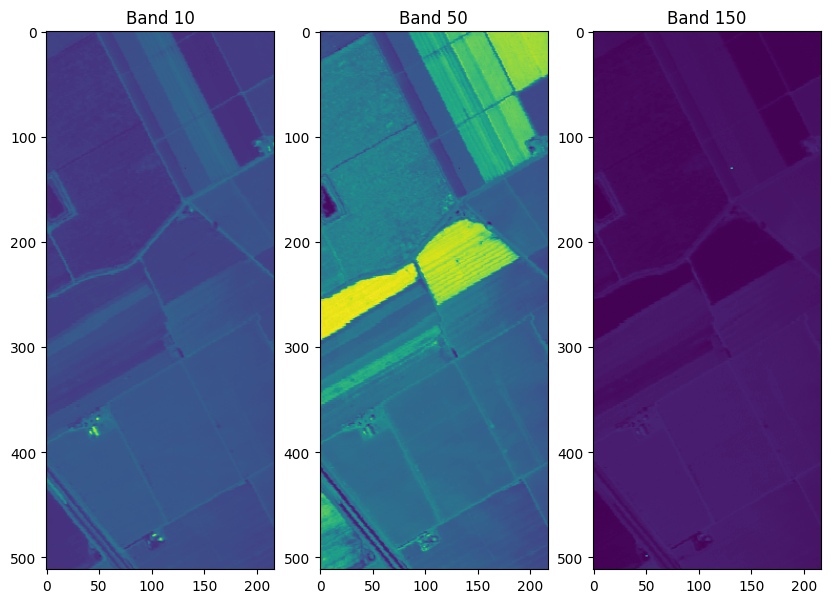

In [7]:
hsi.draw_bands(10, 50, 150)

In [8]:
height, width, bands = hsi.return_shape()
print(height, width, bands)

512 217 204


In [9]:
hsi.number_of_different_categories()

17

In [10]:
X, y = hsi.extract_X_y()

In [11]:
X

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,200,201,202,203
0,290,381,585,1041,1316,1397,1319,1462,1643,1683,...,104,96,109,93,54,79,54,36,11,17
1,290,381,519,1041,1316,1352,1319,1462,1643,1683,...,111,94,111,96,56,83,56,36,11,15
2,290,381,585,1041,1286,1352,1300,1412,1614,1644,...,106,88,107,89,54,81,54,30,11,11
3,290,381,585,999,1316,1374,1280,1380,1584,1631,...,100,86,105,85,56,75,50,30,11,19
4,219,381,585,999,1286,1352,1261,1396,1555,1618,...,96,83,105,83,48,75,50,24,9,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111099,376,405,608,1043,1382,1446,1376,1526,1719,1760,...,141,121,150,124,72,112,76,46,17,27
111100,305,489,608,1086,1353,1446,1357,1510,1704,1760,...,138,126,144,122,76,106,74,40,13,21
111101,447,405,674,1128,1382,1446,1357,1493,1690,1760,...,141,117,146,120,72,108,76,42,11,23
111102,447,405,674,1086,1382,1424,1357,1493,1704,1734,...,136,123,144,122,80,110,78,42,17,27


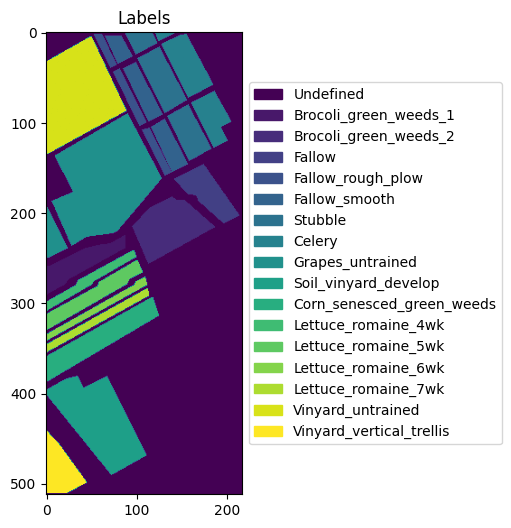

In [12]:
hsi.draw_labels()

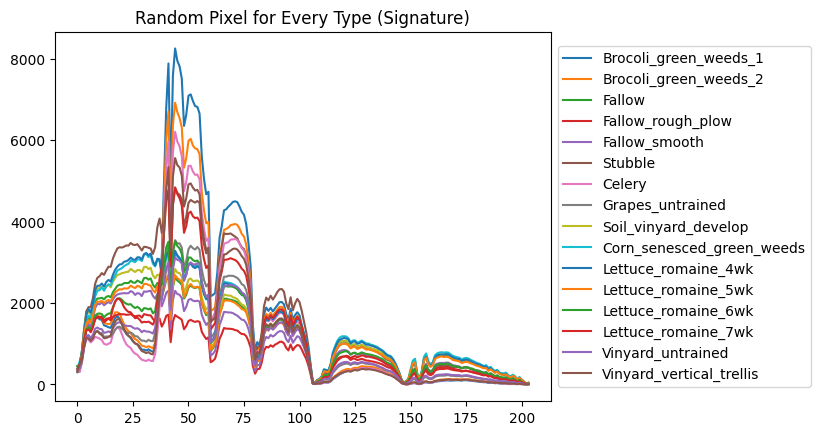

In [13]:
hsi.plot_pixel_signature(hsi.get_random_pixels())

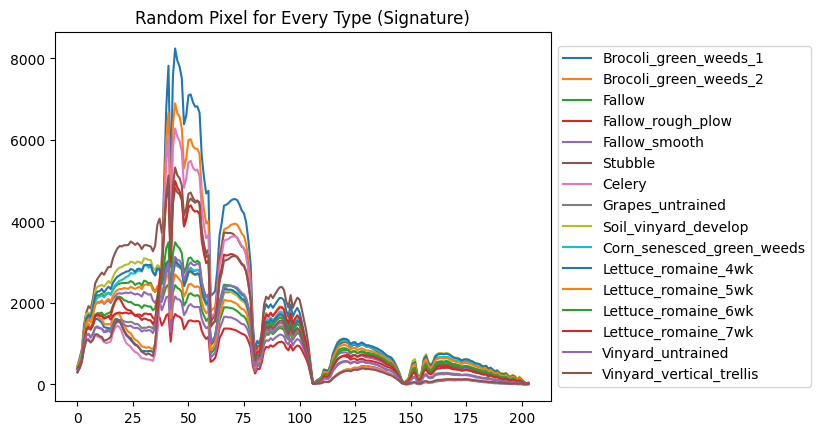

In [14]:
hsi.plot_pixel_signature(hsi.get_random_pixels())

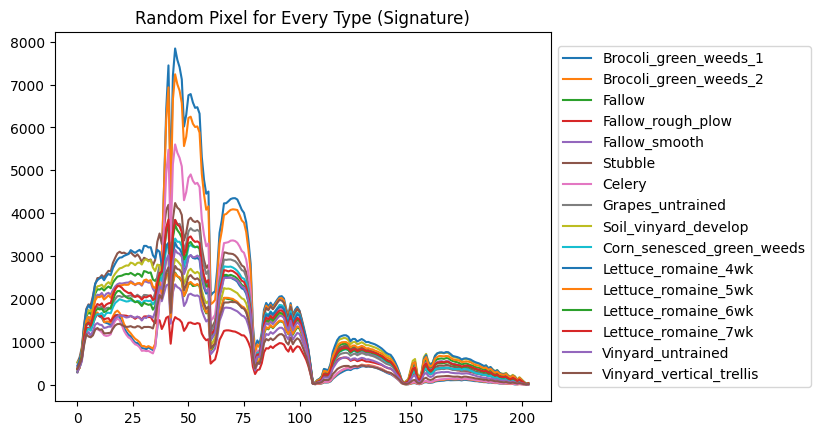

In [15]:
hsi.plot_pixel_signature(hsi.get_random_pixels())

In [16]:
rand_n = np.random.randint(df.shape[0])
rand_n

41024

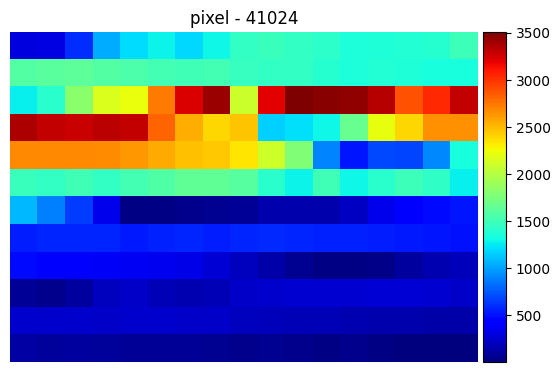

In [17]:
hsi.show_pixel(X.iloc[rand_n, :].values, rand_n)

''

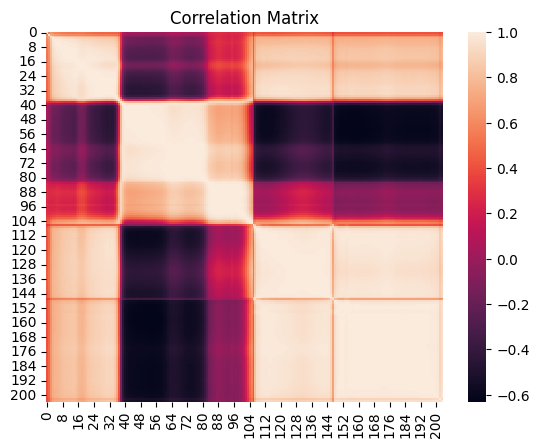

In [18]:
corr_matrix = hsi.get_corr_matrix(X)
import seaborn as sns 
ax = sns.heatmap(corr_matrix)
ax.set_title('Correlation Matrix')
;

In [19]:
X_train = X
X_train = hsi.normalize(X_train)
centroids = hsi.choose_centroids()

In [20]:
kmeans = KMeans(n_clusters=17)
kmeans.fit(X)
kmeans.cluster_centers_ = centroids
y_pred = kmeans.predict(X)
y_np = y.to_numpy()
#adjusted_rand_score(y_pred.flatten(), y_np.flatten())

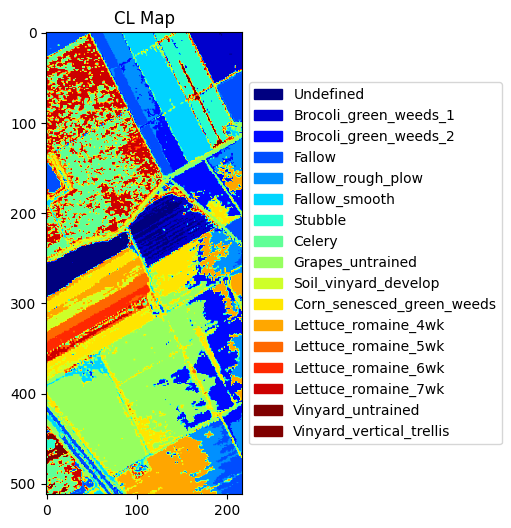

In [21]:
hsi.draw_clmap(y_pred)

In [24]:
pca = PCA(n_components=100)
X_new = pca.fit_transform(X)
y_pred = kmeans.fit_predict(X_new)
#adjusted_rand_score(y_pred.flatten(), y_np.flatten())

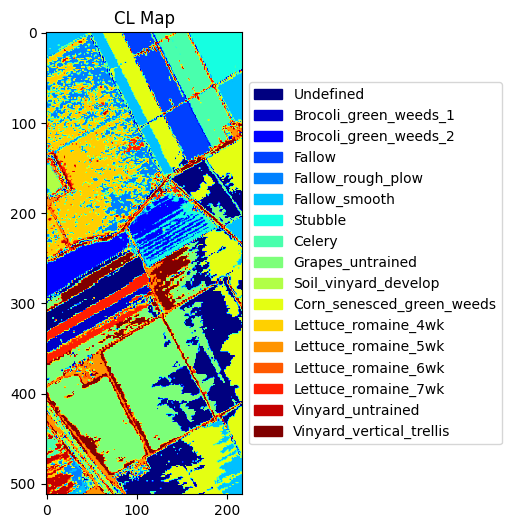

In [25]:
hsi.draw_clmap(y_pred)